In [1]:
# Import functions and libraries
%pylab
import numpy as np
import matplotlib.pyplot as plt
import pyaudio, Queue, threading,time, sys, threading,time, serial
from __future__ import division
from numpy import pi, sin, zeros, r_
from scipy import signal
from rtlsdr import RtlSdr
from scipy import misc
import cPickle as pickle

import bitarray, time, urllib, ssl
from scipy import signal, integrate
from fractions import gcd

import pywt
# plt.rcParams['figure.figsize'] = (16, 16) # (6, 4) for normal size

# import ax25

# # # Serialize object
# f = open('pick_name.pickle', 'wb')
# pickle.dump(NN, f, protocol=pickle.HIGHEST_PROTOCOL)
# f.close()

# Load object
# f = open('picked_name.pickle', 'rb')
# Y = pickle.load(f)
# f.close()

%matplotlib inline
# %pylab

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [93]:
# Resources: HW9, 
#            http://faculty.gvsu.edu/aboufade/web/wavelets/student_work/ef/how-works.html,
#            http://www.dmi.unict.it/~battiato/EI_MOBILE0708/JPEG2000%20(Bruna).pdf

In [570]:
def imshowgray(im, vmin=None, vmax=None):
    plt.imshow(im, cmap=plt.get_cmap('gray'), vmin=vmin, vmax=vmax)

def wavMask(dims, scale):
    sx, sy = dims
    res = np.ones(dims)
    NM = np.round(np.log2(dims))
    for n in range(int(np.min(NM)-scale+2)//2):
        res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))] = \
            res[:int(np.round(2**(NM[0]-n))), :int(np.round(2**(NM[1]-n)))]/2
    return res

def imshowWAV(Wim, scale=1):
    plt.imshow(np.abs(Wim)*wavMask(Wim.shape, scale), cmap = plt.get_cmap('gray'))

def coeffs2img(LL, coeffs):
    LH, HL, HH = coeffs
    return np.vstack((np.hstack((LL, LH)), np.hstack((HL, HH))))

def unstack_coeffs(Wim):
        L1, L2  = np.hsplit(Wim, 2) 
        LL, HL = np.vsplit(L1, 2)
        LH, HH = np.vsplit(L2, 2)
        return LL, [LH, HL, HH]

def img2coeffs(Wim, levels=4):
    LL, c = unstack_coeffs(Wim)
    coeffs = [c]
    for i in range(levels-1):
        LL, c = unstack_coeffs(LL)
        coeffs.insert(0,c)
    coeffs.insert(0, LL)
    return coeffs
    
def dwt2(im, level=1):
    coeffs = pywt.wavedec2(im, wavelet='db4', mode='per', level=level)
    Wim, rest = coeffs[0], coeffs[1:]
    for levels in rest:
        Wim = coeffs2img(Wim, levels)
    return Wim

def idwt2(Wim, levels=1):
    coeffs = img2coeffs(Wim, levels=levels)
    return pywt.waverec2(coeffs, wavelet='db4', mode='per')

In [571]:
def rgb2gray(img):
    # converts RGB img into 1 channel
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

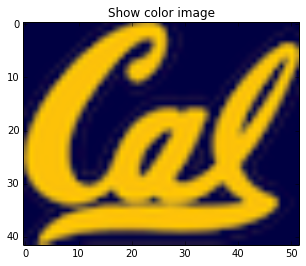

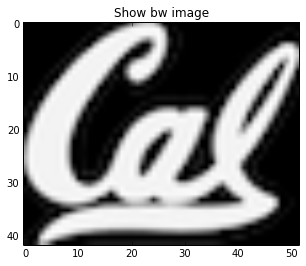

In [572]:
image = misc.imread('imgs/cal_ds.bmp') # load an image
plt.imshow(image)
plt.title('Show color image')

im = rgb2gray(image) # convert to grayscale
plt.figure()
plt.title('Show bw image')
plt.imshow(im, cmap='gray')

In [573]:
im.shape

(42, 52)

In [574]:
# Idea: tile image into 8x8 smaller images. how many fit? what about border tiles? shape?

In [575]:
def num_nonoverlap_tiles(shape, tile_size):
    # shape: image shape, (rows, cols), rows and cols both must be at least tile_size**2.
    # tile_size: number of pixels in an edge of a tile. must be power of 2.
    # returns: num tiles that fit image with shape shape without overlap
    assert log(tile_size)/log(2) % 1 == 0, 'Tile size must be a power of 2.'
    rows, cols = shape
    assert rows >= tile_size and cols >= tile_size, 'Tile size too large.'
    horiz = rows//tile_size
    vert = cols//tile_size
    return horiz, vert

In [576]:
def mean_shift_tiles(image):
    return

In [577]:
# Quantize:

In [578]:
im = np.int32(im) # consider rounding instead.

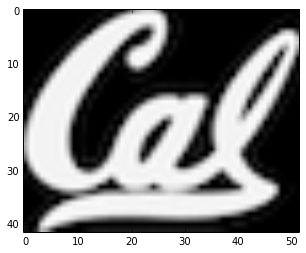

In [579]:
plt.imshow(im, cmap='gray')

In [580]:
im

array([[ 7,  7,  7, ...,  7,  7,  7],
       [ 7,  7,  7, ..., 19, 14,  7],
       [ 7,  7,  7, ...,  7,  7, 20],
       ..., 
       [ 7, 24,  7, ...,  7,  7,  7],
       [18,  7,  7, ...,  7,  7,  7],
       [20,  7, 41, ...,  7,  7,  7]], dtype=int32)

In [581]:
num_nonoverlap_tiles(im.shape, 16)

(2, 3)

In [582]:
# Before the forward discrete wavelet transform, or DWT, is applied to each tile, 
# all image tiles are DC level shifted by subtracting the same quantity, such as the component depth, from each sample.
# DC level shifting involves moving the image tile to a desired bit plane, and is also used for region of interest coding.

In [583]:
# Level shift: (helps with getting chains of zeros in DWT)

In [584]:
bit_depth = log(im.max()-1)/log(2)//1 + 1

In [585]:
im = im - 2**(bit_depth-1)

In [586]:
im

array([[-121., -121., -121., ..., -121., -121., -121.],
       [-121., -121., -121., ..., -109., -114., -121.],
       [-121., -121., -121., ..., -121., -121., -108.],
       ..., 
       [-121., -104., -121., ..., -121., -121., -121.],
       [-110., -121., -121., ..., -121., -121., -121.],
       [-108., -121.,  -87., ..., -121., -121., -121.]])

In [587]:
def map_image_to_square(image):
    # map the original image to power of two.
    larger = max(image.shape)
    next_power_of_2 = (log(larger)//log(2)) + 1
    new_image = np.zeros((2**next_power_of_2,2**next_power_of_2))
    new_image[:image.shape[0],:image.shape[1]] = image
    return new_image

In [750]:
def map_square_to_original(image, shape):
    # map back to the original image.
    # inverse of map_image_to_square
    original = np.zeros(shape)
    original = image[:shape[0],:shape[1]]
    return original

In [588]:
transformed = map_image_to_square(im)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


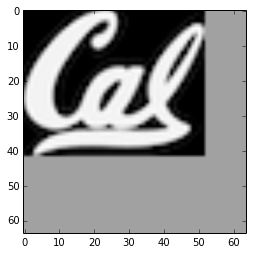

In [770]:
imshow(transformed, cmap = 'gray')

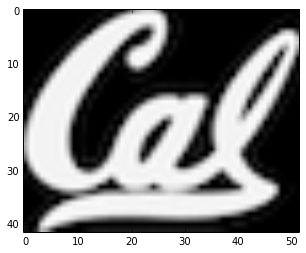

In [769]:
undid = map_square_to_original(transformed, im.shape)
imshow(undid, cmap = 'gray')

In [590]:
def image2tile_partition(image, tile_size):
    # only works for square images with dimension a power of 2
    # tile_size must also be a power of 2.
    # returns list of tiles
    # goes top to bot, l to r.
    assert image.shape[0] == image.shape[1]
    tiles = []
    for i in range(int(image.shape[0]/tile_size)):
        for j in range(int(image.shape[1]/tile_size)):
            tiles += [image[i*tile_size:(i+1)*tile_size,j*tile_size:(j+1)*tile_size]]
    return np.array(tiles)

In [767]:
partition = image2tile_partition(transformed, 16)

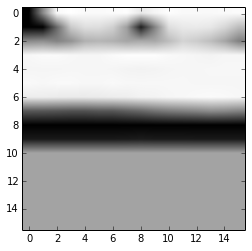

In [768]:
imshow(partition[9,:,:], cmap = 'gray')

In [597]:
def tile_partition2image(tiles):
    # the inverse of image2tile_partition
    # num pixels in tiles must be a power of 2.
    pixels = tiles.shape[0]*tiles.shape[1]*tiles.shape[2]
    side_length = int(sqrt(pixels))
    num_tiles = len(tiles)
    tile_size = partition.shape[1]
    tiles_on_edge = int(side_length/tile_size)
    image = np.zeros((side_length, side_length))
    
    for t in range(len(tiles)):
        image[(t // tiles_on_edge)*tile_size : (t // tiles_on_edge + 1)*tile_size, \
               (t % tiles_on_edge)*tile_size : (t % tiles_on_edge + 1)*tile_size] = tiles[t]
    return image

In [599]:
recon = tile_partition2image(partition)

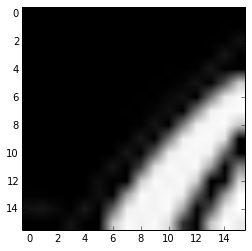

In [765]:
atile = np.copy(partition[2,:,:])
imshow(atile, cmap = 'gray')

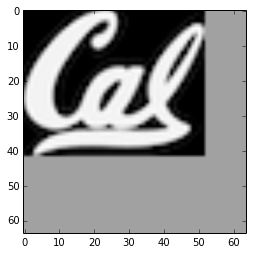

In [764]:
imshow(recon, cmap = 'gray')

In [670]:
def dwt_tiles(tiles):
    # single level db4 wt on each tile.
    dwts = []
    for tile in tiles:
        dwts += [dwt2(tile, 1)]
    return np.array(dwts)

In [676]:
dwt_tiling = dwt_tiles(partition)

In [677]:
partition.shape

(16, 16, 16)

In [678]:
dwt_img = tile_partition2image(dwt_tiling)

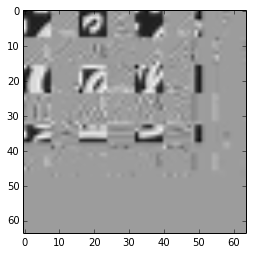

In [763]:
imshow(dwt_img, cmap = 'gray')

In [634]:
# want to only save certain coeffs.

In [680]:
w = dwt_tiles(partition)

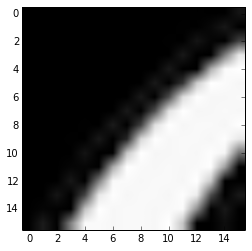

In [762]:
imshow(partition[0], cmap = 'gray')

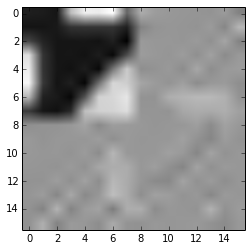

In [761]:
imshow(w[0], cmap = 'gray')

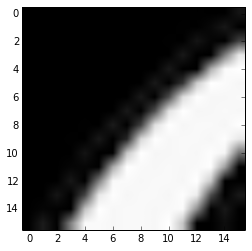

In [760]:
imshow(idwt2(w[0]), cmap = 'gray')

In [684]:
# Compression test: save largest f fraction of wavelets

In [736]:
def thresh_dwt(dwt_tiles, f):
    # f: the fraction f largest wavelet coeffs (to save)
    # parts borrowed from hw9
    thresh_tiles = []
    for tile in dwt_tiles:
        m = np.sort(abs(tile.ravel()))[::-1]
        idx = int(len(m) * f) # the fraction f largest wavelet coeff.
        thr = m[idx] # thr
        thresh_tiles += [tile * (abs(tile) > thr)]
    return np.array(thresh_tiles)

In [746]:
def tile_idwt(tiles):
    idwts = []
    for tile in tiles:
        idwts += [idwt2(tile)]
    return np.array(idwts)

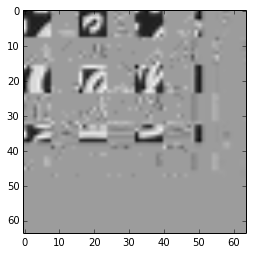

In [771]:
thresh_tiles = thresh_dwt(dwt_tiling, f = 0.4)
imshow(tile_partition2image(thresh_tiles), cmap = 'gray')

In [ ]:
# Quantize dwt coeffs (after thresh)
# figure out rounding!!!

In [ ]:
# Compare values before after quantization

In [786]:
thresh_tiles[0][:][0]

array([-224.94342741, -228.03016528, -241.81118064,   71.6515433 ,
        166.87389283,  157.29031916,  196.16560461,  -92.90251635,
         40.61290845,    0.        ,    0.        ,   -0.        ,
         -0.        ,   -0.        ,    0.        ,  -38.93133693])

In [787]:
thresh_tiles = np.int32(thresh_tiles)

In [788]:
thresh_tiles[0][:][0]

array([-224, -228, -241,   71,  166,  157,  196,  -92,   40,    0,    0,
          0,    0,    0,    0,  -38], dtype=int32)

In [813]:
# Compression comparisons: todo: figure out how to rate compression. 
    # sparsity? 
    # ????
print('L1 norm ratio thingy',np.sum(abs(tile_partition2image(thresh_tiles)))/np.sum(abs(dwt_img)))
print('L2 norm ratio thingy',np.linalg.norm(tile_partition2image(thresh_tiles)/np.linalg.norm(dwt_img)))
print('L2 ratio thingy',np.linalg.norm(tile_partition2image(thresh_tiles) - dwt_img)/np.linalg.norm(dwt_img))

('L1 norm ratio thingy', 0.90900496269482556)
('L2 norm ratio thingy', 0.99270924425527496)
('L2 ratio thingy', 0.091683785581566132)


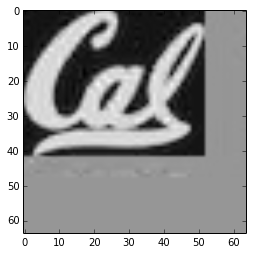

In [789]:
idwts = tile_idwt(thresh_tiles)
idwts_img = tile_partition2image(idwts)
imshow(idwts_img, cmap = 'gray')

In [790]:
cmprsd = map_square_to_original(idwts_img, im.shape)

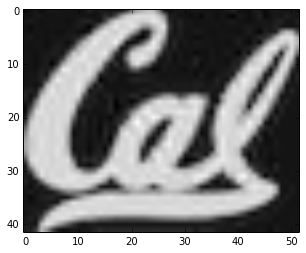

In [791]:
imshow(cmprsd, cmap = 'gray')

In [ ]:

# def compress(image):
    